# Coral Species Identification with fastai, a Paper Comparison
> Part 1 of implementing and attempting to improve the ideas from a paper
* toc: true
* badges: true
* comments: true
* image: images/chart-preview.png
* category: Papers

---
This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any Jupyter environment. This post was written using:

* `fastai2`: 0.0.13

* `fastcore`: 0.1.15
---

# What is this series?

This new series of blogs will be focused on implementing various papers and attempting to beat benchmarks with the tools and techniques Fast.AI teaches. The paper we will be focusing on for this first part is [Coral species identification with texture or structure images using a two-level classifier based on Convolutional Neural Networks](https://www.researchgate.net/publication/334753269_Coral_species_identification_with_texture_or_structure_images_using_a_two-level_classifier_based_on_Convolutional_Neural_Networks) by Gomez-Rios, Tabik, et al. I wanted to try this paper and dataset out because I was originally a marine biology major before switching to computer science and doing machine learning, and I've been wanting to take the tools I've learned and apply it back into the field. For a quick ELI5 of what a coral is, corals are actually living animals that pack themselves into a skeleton, living as one giant body. These skeletons are then what we see in the ocean (and what's left after coral bleaching!)

# The Paper

In this paper, they describe a problem for underwater identification of corals where the current methods are very unreliable and complicated because the datasets are unrealistic. These datasets provide texture-based images while images taken in practice, say by underwater vehicles, are the complete coral structure. For reference, here is a snippet from their paper:

![](https://i.imgur.com/ikxhHV3.png)

As we can see, the texture images are *much* closer than the structured images. 

These images come from the RSMAS dataset linked [here](https://data.mendeley.com/datasets/86y667257h/2). With this dataset as a guide, the authors introduce a new dataset: [StructureRSMAS](http://sci2s.ugr.es/CNN-coral-image-classification). While RSMAS has 766 256 by 256 pixel images of the coral textures, StructureRSMAS contains images of a variety of size, with 409 total pictures. For this first post, we'll be focusing on their results from StructureRSMAS dataset.

We'll be focusing on the **Structure Classifier** in this article and the StructureRSMAS dataset

In the paper they also mention how the overall final structure of the models are. Essentially they have a pyramid of models that are run dependant on the model prior to it. See the visualization below:

![](https://i.imgur.com/AJFWiC0.png)

## Their Experiment Design

When training on StructureRSMAS, the authors looked at three different architecture designs, three different number of training epochs, and three different batch sizes. Their work was done in TensorFlow, so there's ample opportunity to bring in some of the `fastai` functionalities. Here was their hyperparameters they tested (table from page 17): 

![](https://i.imgur.com/L1xfBiP.png)

What they found through their experiments was that a ResNet 50 at 300 epochs and a batch size of 32 had the highest accuracy of 83.158% without image augmentation. From here, they tried a variety of image enhancements such as Debluring, Saliency, and Contrast and Brightness Enhancement. Using a Deblurring method they further increased the accuracy to 85%. Afterwards they tried a variety of image augmentations and found it did not improve the accuracy. The results of these experiments are the average of a five-fold Cross Validation on the data. Now that we know how it was set up, we can try fitting in `fastai` functionalities to beat this benchmark.

# Bringing in `fastai`

With a benchmark to work off of let's see if we can apply the `fastai` framework here with two goals in mind:
* Higher accuracy
* Less time training

First, let's grab the library:



In [0]:
from fastai2.vision.all import *

As this notebook can be run top-down in Jupyter, we'll also grab the dataset in-line

In [0]:
url = 'https://sci2s.ugr.es/sites/default/files/files/ComplementaryMaterial/CoralClassification/StructureRSMAS.zip'

In [0]:
!wget {url} -O coral.zip -q

In [0]:
from zipfile import ZipFile
with ZipFile('coral.zip', 'r') as zip_ref:
  zip_ref.extractall('coral')

Let's look at how they have their data structured:

In [0]:
path = Path('coral/StructureRSMAS')

In [117]:
path.ls()[:2]

(#2) [Path('coral/StructureRSMAS/APAL'),Path('coral/StructureRSMAS/MMEA')]

We can see that each category is stored inside of its own folder, so let's build a `DataBlock` for this. (For those who are unfamilair with the new API, read my post [here](https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html). 

## The `DataBlock`

For augmentation, we'll utilize a presizing method taught by Jeremy, along with some augmentation. This includes increasing the brightness and contrast, something that the authors found improved the results. When doing Pre-sizing, you'd generally take an image that is large and resize it to a much smaller size through cropping (either randomly cropping the image or cropping at the center), and then I *further* shrink this image size down. What this allows is smaller or more uncommon features in the image have a chance to be fully scene to our network. This has an advantage when your input images are all a variety of  sizes and shapes. 

In [0]:
item_tfms = Resize(256)
batch_tfms = [RandomResizedCrop(224), *aug_transforms(mult=1.0, do_flip=True, max_rotate=30.0, max_zoom=1.5,
                            max_lighting=.8, max_warp=0.3, p_lighting=.9)]

In [0]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter = RandomSplitter(),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

We'll build our `DataLoaders` using the same batch size too:

In [0]:
dls = block.dataloaders(path, bs=32)

Let's look at a batch

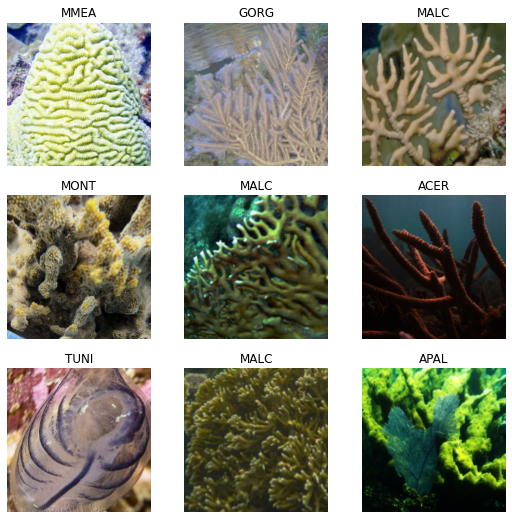

In [147]:
dls.show_batch()

## Training, and what we will be doing *differently*
For their experiments they used 5 Folds for K-Fold Cross Validation, we'll recreate the process based on [this](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/03_Cross_Validation.ipynb) notebook. We'll also use a few different image augmentations and Test Time Augmentation (TTA), the prior was not explored much and the latter was not used at all. TTA is explained further in the article. Also to note: as the dataset is extremely small we won't have a hold-out test set we evaluate on.

In [0]:
from sklearn.model_selection import StratifiedKFold

We'll get some setups to use scikit-learn's [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) in the library, specifically our training images:

In [0]:
imgs = get_image_files(path)

Shuffle them around

In [0]:
random.shuffle(imgs)

And then grab their labels

In [0]:
lbls = [parent_label(im) for im in imgs]

We'll also be utilizing the progressive resizing technique, where we train initially on a smaller set of images before moving upwards to a larger size. We're doing this as our data comes from a variety of sized images, so this will be a good way to get the most out of our data. 

Now you're probably confused about the difference between **pre-sizing** and **progressive resizing**. I'll try to explain the difference. **Pre-sizing** is where we *initially* make our image larger before applying a random crop of the image (such as 256x256 to 224x224). This can bring an opportunity for some smaller or finer details to show up more prominantly.

**Progressive resizing** is a technique where we start *training* at a small image size and then increase this image size while training. Here we'll start at an image size of 128x128 and then train on an image size of 224x224 afterwards

Now let's make a function to help us build our `DataLoaders` in such a way as to support progressive resizing

In [0]:
def get_dls(bs, size, val_idx):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=IndexSplitter(val_idx),
                   item_tfms = Resize(256),
                   batch_tfms = [RandomResizedCrop(size), 
                                 *aug_transforms(mult=1.0, do_flip=True, 
                                                 max_rotate=30.0, max_zoom=1.5,
                                                  max_lighting=.8, max_warp=0.3, 
                                                 p_lighting=.9),
                                 Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

To use Stratified K-Fold Cross Validation in `fastai`, we'll use an `IndexSplitter` to pass it into the framework. Now from here our training loop will be setup to first train on 128x128 sized images for three epochs, followed by increase the size to 224x224 and train for six more. In most cases they will not run for this full time however as EarlyStopping is being used to cut-off training once the model stops improving. 

From here we will employ "Test Time Augmentation" and report back the accuracy, which will then be averaged from all models. Test Time Augmentation is a technique where you also perform some augmentation on your test data, as it sounds like. In `fastai` this operates by making copies of your test images and augmenting them. By default it will make 3 copies and then these results are averaged. This has been shown to have the potential to further increase your accuracy. We'll take it for a test drive now:

* Note, the output from training is not displayed as this takes a large amount of article space to run, I have summarized the results below this code block.

In [0]:
val_pct = []
skf = StratifiedKFold(n_splits=5, shuffle=True)
i = 0

for _, val_idx in skf.split(np.array(imgs), lbls):
  dls = get_dls(32, 128, val_idx)
  learn = cnn_learner(dls, resnet50, metrics=accuracy)
  learn.fine_tune(2, cbs=[EarlyStoppingCallback(monitor='accuracy')])
  learn.dls = get_dls(32, 224, val_idx)
  learn.fine_tune(5, 1e-3, cbs=[EarlyStoppingCallback(monitor='accuracy')])
  preds,targs = learn.tta()
  print(accuracy(preds, targs).item())
  val_pct.append(accuracy(preds, targs).item())
  i+=1

# Results

The results from our training were:

* Fold 1: 82.9%
* Fold 2: 89.0%
* Fold 3: 89.0%
* Fold 4: 90.2%
* Fold 5: 90.1%

All of these folds then further average to 88%, outperforming the 83% they found without augmentation, and the 85% used *with* augmentation. There's many little neat "tricks" the `fastai` library provides and each one can increase and further how your model performs. When we began this article there were two goals in mind, let's review them:

* Decrease training time:
  * The paper trained for 300 total epochs, we brought it down to **nine**
* Increase accuracy:
  * The paper had an accuracy at *best* of 85%, we were able to boost it to 88%, with one instance where the accuracy was 90%.
  * Note: I did run a test with just Resizing and could match their baseline of ~83%

In the next blog we'll take a look at the other ideas that were implemented in the paper and compare how different optimizers may perform on the data.